# Fully Synthesizable Voltage DAC and Temperature Sensor using Tristate-Inverters

Copyright 2022 **Manuel Moser(*), Michael Herber, and Harald Pretl**, Institute for Integrated Circuits, Johannes Kepler University, Linz, Austria.

SPDX-License-Identifier: Apache-2.0  

Submission for Category 2: A new idea that could be the basis for a future tapeout

(\*) Graduate-student nominated for travel to ISSCC 2023.  
(\*) e-Mail: moser.manuel@mailbox.org

## Abstract

Based on the creative use of a tristate-inverter (available in the SKY130 standard cell library) a number of mixed-mode circuit blocks can be implemented in a Verilog-based RTL2GDS flow. As a proof-of-concept we demonstrate the realization of a voltage-mode digital-to-analog converter (DAC). This DAC can be readily used in a successive-approximation-register analog-to-digital converter (SAR ADC), and also allows the implementation of a digitally-controlled delay-cell (DCDC), as is demonstrated in this notebook. We use this DCDC, using MOSFET biased in weak inversion, in a synthesizable digital temperature sensor using only standard cells.

## Introduction

There is a lot of recent interest [1,2,3,4] in realizing analog circuit functions in a fully digital way using an RTL2GDS flow as much as possible. We propose the creative use of a tristate-inverter, which is available in the SKY130 standard cell library (for implementating bi-directional bus structures). The transistor-level schematic of this tristate-inverter is shown in Fig. 1, and this versatile cell allows to implement:

* A programmable-strength self-biased inverter (alternatively, this can be seen as a voltage divider consisting of a diode-connected pMOST and a diode-connected nMOST).
* A programmable-strength pull-down transistor.
* A programmable-strength pull-up transistor.

These three modes are visualized in Fig. 2.

## Synthesizable Voltage-Mode DAC

Previous work [4] has proven the feasibility of synthesizing a DAC using only OAI22-gates, but the OAI22 standard cells lack a high-Z functionality and thus cannot be completely turned off. By using the inherent programmability of the tristate-inverter, a voltage-mode DAC with high-Z functionality can be built, which is shown in the implementation section of this notebook. By looking at the schematic in Fig. 2, the DAC can be realized by selectively switching the tristate-inverters into voltage-reference, pull-up, pull-down, or high-Z configuration. In our implementation, we use the following switching scheme, exemplary shown for a 3-bit DAC:


| Input | Configuration    | Switching scheme   |
|-------|------------------|--------------------|
| 000   | 4x pull-down     | DDDD |  
| 001   | 3x pull-down, 1x voltage-reference     | RDDD |  
| 010   | 2x pull-down, 2x voltage-reference     | DRRD |  
| 011   | 1x pull-down, 3x voltage-reference     | RRRD |  
| 100   | 3x voltage-reference, 1x high-Z     | RRRZ |  
| 101   | 1x pull-up, 2x voltage-reference, 1x high-Z     | URRZ |  
| 110   | 2x pull-up, 1x voltage-reference, 1x high-Z     | RUUZ |  
| 111   | 3x pull-up, 1x high-Z     | UUUZ |  

: Table 1, VDAC switching scheme

This scheme can be expressed in a generalized notation for an $N$-bit input word $D_\mathrm{in}$, which is shown in Table 2.

| Condition | Pulldown    | VREF   | Pullup     | High-Z |
|----------|-------------|--------|------------|--------|
| $$D_\mathrm{in} < 2^{N-1}$$ | $$2^{N-1}-D_{in}$$ | $$D_{in}$$ | $$0$$ |$$0$$  |
| $$D_\mathrm{in} \ge 2^{N-1}$$  | $$0$$  | $$2^{N}-D_{in}-1$$ | $$D_{in}-2^{N-1}$$ |  $$1$$  |   

: Table 2, VDAC switching generalized notation

The analog simulation of a 6-bit implementation further down in this notebook is shown in Fig. 5.

## Synthesizable Digital Temperature Sensor

As has been shown by [2,3] and others, using the temperature-sensitive delay of a digital inverter a temperature sensor can be constructed. If the inverter is biased in weak inversion then the temperature-dependency is large and can be measured easily. 

Inspecting the transistor-level implementation of the tristate-inverter in Fig. 1 it can be seen that a current-starved inverter can be built by using the voltage-mode DAC described earlier to apply a low-level voltage (less than $V_\mathrm{th}$) to the `enable` input so that the lowest nMOST is biased in weak inversion, while the top pMOST branch is turned off. We use this current-starved inverter to discharge the input capacitance of a following buffer after pre-charging it first to $V_\mathrm{DD}$. The generation of a delay works as follows:

  1. The DAC output (connected to the `enable`-pin) is switched to $V_\mathrm{DD}$ and thus the tristate-inverter is fully enabled. The data input is set to `0` so that the output (and thus the corresponding parasitic load capacitance) is pre-charged to $V_\mathrm{DD}$.
  2. The DAC output is set to a low voltage (e. g. 0.3V) so that the lower nMOS of the lower leg is biased in subthreshold conduction, while the DCDC output remains at $V_\mathrm{DD}$. This is done to prevent conflicting drain currents resulting from simultaneously switched data-input (fast) and the analog bias-voltage (slow).
  3. Then, the DCDC data input is set to `1` so that the upper nMOS of the lower leg is turned on (see Fig. 1). The resulting small current (which has a large temperature dependency) is then discharging the parasitic load capacitance.
  4. Once the tripping point of the following inverter is reached (at around $V_\mathrm{DD} / 2$) the delay-time has expired and the whole process is finished. 

Since this delay-time varies considerably with temperature due to the strong exponential funcion of the drain current in subthreshold operation, plus the temperature dependency of the voltage-mode DAC output, we adopted the following readout strategy of the temperature sensor:

  1. In a first step, a coarse alignment of the delay-time is done: The MSB of the DAC is evaluated by testing the delay, and depending if the delay is longer or shorter than a preset ideal value, the DAC is switched accordingly.
  2. This step is repeated in a SAR-like fashion for all remaining DAC bits.
  3. After the coarse alignment via the DAC has been done the residual delay-time is measured. 
  4. Both results (the DAC value plus the final delay-time measurement) are the result of the temperature measurement and are further sent to a host system for evaluation.

The timing diagram of the described measurement control flow is shown in Fig. 4. In our implementation we assume a 10MHz clock frequency, but this can be adapted easily.

To confirm the proper functionality of the proposed temperature sensor we have executed a mixed-mode simulation in `ngspice` using the `XSPICE` extension. The DAC and delay-cell are simulated at transistor level, while the control logic is simulated functionally to speed up the simulation. The simulation result for SS/TT/FF corners in a range of $-30\,^\circ \mathrm{C}$ to $125\,^\circ \mathrm{C}$ is shown in Figs. 6 and 7.

## Conclusion

We present a fully-synthesizable DAC and temperature sensor which are implemented using exclusively standard cells without resorting to custom-made extensions. This is possible by exploiting non-traditional uses of the tristate-inverter. The functionality of the DAC and the temperature sensor is shown over the full temperature range and across process corners in a mixed-mode circuit simulation. The proposed design is hardened from a Verilog model using the OpenLane RTL2GDS flow and SKY130 standard cell libraries.

## References

[1] P. Toledo, et al., "_Re-Thinking Analog Integrated Circuits in Digital Terms: A New Design Concept for the IoT Era_," IEEE Trans. Circ. Syst., 2021.

[2] T. Anand, K. A. A. Makinwa, and P. K. Hanumolu, "_A VCO Based Highly Digital Temperature Sensor With 0.034 °C/mV Supply Sensitivity_," IEEE J. Solid-St. Circ.,2016.

[3] Q. Zhang, et al., "_An Open-Source and Autonomous Temperature Sensor Generator Verified With 64 Instances in SkyWater 130 nm for Comprehensive Design Space Exploration_," IEEE Solid-State Circuits Lett., 2022.

[4] J. -E. Park, Y. -H. Hwang, and D. -K. Jeong, "_A 0.5-V Fully Synthesizable SAR ADC for On-Chip Distributed Waveform Monitors_," IEEE Access, 2019.


### Setting up the environment
This is the first task to do

In [1]:
# import python modules and install all tools and dependencies
import os
import pathlib
import sys
import IPython.display
!pip install matplotlib pandas pyinstaller 
!apt-get install -y ruby-full time build-essential
!apt install -f libqt4-designer libqt4-xml libqt4-sql libqt4-network libqtcore4 libqtgui4
!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
site_package_path = conda_prefix_path / 'lib/python3.7/site-packages'
sys.path.append(str(site_package_path.resolve()))
CONDA_PREFIX = str(conda_prefix_path.resolve())
PATH = os.environ['PATH']
LD_LIBRARY_PATH = os.environ.get('LD_LIBRARY_PATH', '')
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}
%env LD_LIBRARY_PATH={CONDA_PREFIX}/lib:{LD_LIBRARY_PATH}
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel litex-hub \
                        --channel main \
                        open_pdks.sky130a \
                        magic \
                        netgen \
                        openroad \
                        yosys
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel conda-forge \
                        tcllib gdstk pyyaml click svgutils           

# Layout viewer, prerequisite for OpenLane
!wget https://www.klayout.org/downloads/Ubuntu-18/klayout_0.27.11-1_amd64.deb
!dpkg -i klayout_0.27.11-1_amd64.deb

# Digital RTL to GDSII flow
!git clone --depth=1 https://github.com/The-OpenROAD-Project/OpenLane  

# Python package for drawing circuits
!pip install schemdraw==0.14


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 594 kB 29.6 MB/s 
     |████████████████████████████████| 250 kB 67.1 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-lato javascript-common libgmp-dev libgmpxx4ldbl libjs-jquery
  libruby2.5 rake ri ruby ruby-dev ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5 ruby2.5-dev
  ruby2.5-doc rubygems-integration
Suggested packages:
  apache2 | lighttpd | httpd gmp-doc libgmp10-doc libmpfr-dev bundler
The following NEW packages will be installed:
  fonts-lato javascript-common libgmp-dev libgmpxx4ldbl libjs-

### Figure 1: Transistor-level implementation of the `SKY130A` tristate-inverter standard cell `sky130_fd_sc_hd__einvp_1`

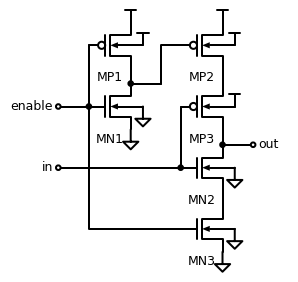

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import schemdraw
import schemdraw.elements as elm
import schemdraw.logic as logic
elm.style(elm.STYLE_IEC)
with schemdraw.Drawing() as d:
  MN2=d.add(elm.NFet(bulk=True,reverse=True).label('MN2',loc='bot').at((4,2)))
  MN3=d.add(elm.NFet(bulk=True,reverse=True).label('MN3',loc='bot').at((4,0)))
  MP3=d.add(elm.PFet(bulk=True,reverse=True).label('MP3',loc='bot').at((4,4)))
  MP2=d.add(elm.PFet(bulk=True,reverse=True).label('MP2',loc='bot').at((4,6)))
  
  MN1=d.add(elm.NFet(bulk=True,reverse=True).label('MN1',loc='bot').at((1,4)))
  MP1=d.add(elm.PFet(bulk=True,reverse=True).label('MP1',loc='bot').at((1,6)))

  # Vdd
  d.add(elm.Vdd().at(MP1.source))
  d.add(elm.Vdd().at(MP2.source))
  # Gnd
  d.add(elm.GroundSignal().at(MN1.source))
  d.add(elm.GroundSignal().at(MN3.source))
  # Bulk
  d.add(elm.Line().at(MP1.bulk).right().length(0.4))
  d.add(elm.Vdd())
  d.add(elm.Line().at(MP2.bulk).right().length(0.4))
  d.add(elm.Vdd())
  d.add(elm.Line().at(MP3.bulk).right().length(0.4))
  d.add(elm.Vdd())
  d.add(elm.Line().at(MN1.bulk).right().length(0.4))
  d.add(elm.GroundSignal())
  d.add(elm.Line().at(MN2.bulk).right().length(0.4))
  d.add(elm.GroundSignal())
  d.add(elm.Line().at(MN3.bulk).right().length(0.4))
  d.add(elm.GroundSignal())

  # connections from High-Z enable-inverter 
  d.add(elm.Wire('-',k=-0.5).at(MP1.gate).to(MN1.gate))
  d.add(elm.Wire('-').at(MP1.drain).to(MN1.drain))
  d.add(elm.Dot().at(MN1.drain))
  d.add(elm.Line().length(1).right())
  d.add(elm.Wire('|-').to(MP2.gate))
  # connections from main-inverter
  d.add(elm.Wire('-').at(MP2.drain).to(MP3.source))
  d.add(elm.Wire('-').at(MP3.drain).to(MN2.drain))
  d.add(elm.Wire('-').at(MN2.source).to(MN3.drain))
  d.add(elm.Wire('-',k=-0.5).at(MP3.gate).to(MN2.gate))
  d.add(elm.Wire('-|').at(MN3.gate).to(MN1.gate))

  # Ports
  d.add(elm.Line(arrow='o-').left().at(MN2.gate).length(4))
  d.add(elm.Dot(open=True).label('in',loc='left'))
  d.add(elm.Line(arrow='o-').left().at(MN1.gate).length(1))
  d.add(elm.Dot(open=True).label('enable',loc='left'))
  d.add(elm.Line(arrow='o-').right().at(MN2.drain).length(1))
  d.add(elm.Dot(open=True).label('out',loc='right'))


### Figure 2: The 3 modes of a tristate-inverter based Voltage-mode Digital-to-Analog Converter (VDAC) Unitcell

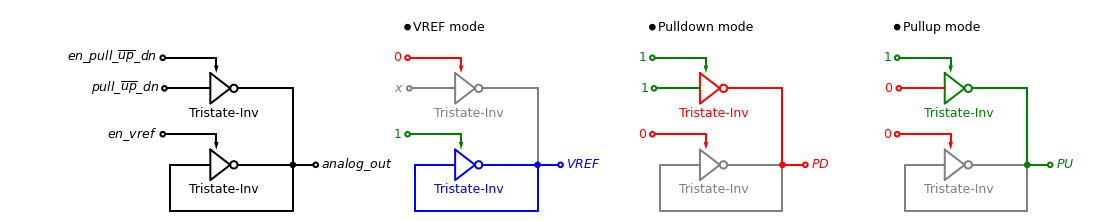

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import schemdraw
import schemdraw.elements as elm
import schemdraw.logic as logic
elm.style(elm.STYLE_IEC)

with schemdraw.Drawing() as d:

  d.add(elm.Dot().at((8,7.5)).label('VREF mode',loc='right'))
  d.add(elm.Dot().at((16,7.5)).label('Pulldown mode',loc='right'))
  d.add(elm.Dot().at((24,7.5)).label('Pullup mode',loc='right'))

  einvp1 = d.add(logic.Not().label('Tristate-Inv',loc='bottom').at((0.5,5.5)))
  einvp2 = d.add(logic.Not().label('Tristate-Inv',loc='bottom').at((0.5,3)))
  d.add(elm.Line().right().length(0.75))
  d.push()
  d.add(elm.Line().down().length(1.5))
  d.add(elm.Line().left().length(4))
  d.add(elm.Line().up().length(1.5))
  d.add(elm.Line().right().length(0.75))
  d.pop()
  d.push()
  d.add(elm.Dot())
  d.add(elm.Line().right().length(0.75))
  d.add(elm.Dot(open=True).label('$analog\_out$',loc='right'))
  d.pop()
  d.add(elm.Line().up().length(2.5))
  d.add(elm.Line().left().length(1))
  d.add(elm.Line().left().at(einvp1.in1).length(1.5))
  d.add(elm.Dot(open=True).label('$pull\_\overline{up}\_dn$',loc='left'))
  d.add(elm.Dot(open=True).at((0,6.5)).label('$en\_pull\_\overline{up}\_dn$',loc='left'))
  d.add(elm.Line().right().length(1.75))
  d.add(elm.Line(arrow='->').down().length(0.5))
  d.add(elm.Dot(open=True).at((0,4)).label('$en\_vref$',loc='left')) 
  d.add(elm.Line().right().length(1.75))
  d.add(elm.Line(arrow='->').down().length(0.5)) 

  # REF
  einvp3 = d.add(logic.Not().color('grey').right().label('Tristate-Inv',loc='bottom').at((8.5,5.5)))
  einvp4 = d.add(logic.Not().color('blue').label('Tristate-Inv',loc='bottom').at((8.5,3)))
  d.add(elm.Line().right().color('blue').length(0.75))
  d.push()
  d.add(elm.Line().down().color('blue').length(1.5))
  d.add(elm.Line().left().color('blue').length(4))
  d.add(elm.Line().up().color('blue').length(1.5))
  d.add(elm.Line().right().color('blue').length(0.75))
  d.pop()
  d.push()
  d.add(elm.Dot().color('blue'))
  d.add(elm.Line().right().color('blue').length(0.75))
  d.add(elm.Dot(open=True).color('blue').label('$VREF$',loc='right'))
  d.pop()
  d.add(elm.Line().up().color('grey').length(2.5))
  d.add(elm.Line().left().color('grey').length(1))
  d.add(elm.Line().left().color('grey').at(einvp3.in1).length(1.5))
  d.add(elm.Dot(open=True).color('grey').label('$x$',loc='left'))
  d.add(elm.Dot(open=True).color('red').at((8,6.5)).label('$0$',loc='left'))
  d.add(elm.Line().color('red').right().length(1.75))
  d.add(elm.Line(arrow='->').color('red').down().length(0.5))
  d.add(elm.Dot(open=True).color('green').at((8,4)).label('$1$',loc='left')) 
  d.add(elm.Line().color('green').right().length(1.75))
  d.add(elm.Line(arrow='->').color('green').down().length(0.5)) 


  # PD
  einvp5 = d.add(logic.Not().color('red').right().label('Tristate-Inv',loc='bottom').at((16.5,5.5)))
  einvp6 = d.add(logic.Not().color('grey').label('Tristate-Inv',loc='bottom').at((16.5,3)))
  d.add(elm.Line().right().color('grey').length(0.75))
  d.push()
  d.add(elm.Line().down().color('grey').length(1.5))
  d.add(elm.Line().left().color('grey').length(4))
  d.add(elm.Line().up().color('grey').length(1.5))
  d.add(elm.Line().right().color('grey').length(0.75))
  d.pop()
  d.push()
  d.add(elm.Dot().color('red'))
  d.add(elm.Line().right().color('red').length(0.75))
  d.add(elm.Dot(open=True).color('red').label('$PD$',loc='right'))
  d.pop()
  d.add(elm.Line().up().color('red').length(2.5))
  d.add(elm.Line().left().color('red').length(1))
  d.add(elm.Line().left().color('green').at(einvp5.in1).length(1.5))
  d.add(elm.Dot(open=True).color('green').label('$1$',loc='left'))
  d.add(elm.Dot(open=True).color('green').at((16,6.5)).label('$1$',loc='left'))
  d.add(elm.Line().color('green').right().length(1.75))
  d.add(elm.Line(arrow='->').color('green').down().length(0.5))
  d.add(elm.Dot(open=True).color('red').at((16,4)).label('$0$',loc='left')) 
  d.add(elm.Line().color('red').right().length(1.75))
  d.add(elm.Line(arrow='->').color('red').down().length(0.5)) 

  # PU
  einvp7 = d.add(logic.Not().color('green').right().label('Tristate-Inv',loc='bottom').at((24.5,5.5)))
  einvp8 = d.add(logic.Not().color('grey').label('Tristate-Inv',loc='bottom').at((24.5,3)))
  d.add(elm.Line().right().color('grey').length(0.75))
  d.push()
  d.add(elm.Line().down().color('grey').length(1.5))
  d.add(elm.Line().left().color('grey').length(4))
  d.add(elm.Line().up().color('grey').length(1.5))
  d.add(elm.Line().right().color('grey').length(0.75))
  d.pop()
  d.push()
  d.add(elm.Dot().color('green'))
  d.add(elm.Line().color('green').right().length(0.75))
  d.add(elm.Dot(open=True).color('green').label('$PU$',loc='right'))
  d.pop()
  d.add(elm.Line().up().color('green').length(2.5))
  d.add(elm.Line().left().color('green').length(1))
  d.add(elm.Line().left().color('red').at(einvp7.in1).length(1.5))
  d.add(elm.Dot(open=True).color('red').label('$0$',loc='left'))
  d.add(elm.Dot(open=True).color('green').at((24,6.5)).label('$1$',loc='left'))
  d.add(elm.Line().color('green').right().length(1.75))
  d.add(elm.Line(arrow='->').color('green').down().length(0.5))
  d.add(elm.Dot(open=True).color('red').at((24,4)).label('$0$',loc='left')) 
  d.add(elm.Line().color('red').right().length(1.75))
  d.add(elm.Line(arrow='->').color('red').down().length(0.5)) 

### Figure 3: Detailed Transistor-Level Schematic of VDAC Unitcell and Truthtable
Combination of two tristate-inverters `sky130_fd_sc_hd__einvp_1` for a programmable self-biased inverter and a programmable pull-up/-down MOSFET.

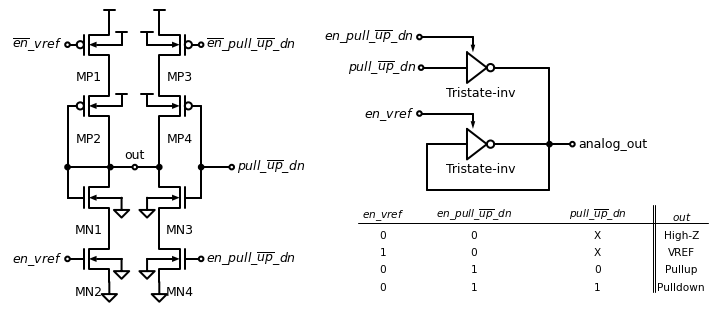

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import schemdraw
import schemdraw.elements as elm
import schemdraw.logic as logic
elm.style(elm.STYLE_IEC)

with schemdraw.Drawing() as d:

  ## VREF mode
  MP1=d.add(elm.PFet(bulk=True,reverse=True).label('MP1',loc='bot').at((1,7)))
  MP2=d.add(elm.PFet(bulk=True,reverse=True).label('MP2',loc='bot').at((1,5)))
  MN1=d.add(elm.NFet(bulk=True,reverse=True).label('MN1',loc='bot').at((1,2)))
  MN2=d.add(elm.NFet(bulk=True,reverse=True).label('MN2',loc='bot').at((1,0)))
  # Vdd
  d.add(elm.Vdd().at(MP1.source))
  # Gnd
  d.add(elm.GroundSignal().at(MN2.source))
  # Bulk
  d.add(elm.Line().at(MP1.bulk).right().length(0.4))
  d.add(elm.Vdd())
  d.add(elm.Line().at(MP2.bulk).right().length(0.4))
  d.add(elm.Vdd())
  d.add(elm.Line().at(MN1.bulk).right().length(0.4))
  d.add(elm.GroundSignal())
  d.add(elm.Line().at(MN2.bulk).right().length(0.4))
  d.add(elm.GroundSignal())
  # interconnect
  d.add(elm.Wire('-').at(MP1.drain).to(MP2.source))
  d.add(elm.Wire('-').at(MP2.drain).to(MN1.drain))
  d.add(elm.Wire('-').at(MN1.source).to(MN2.drain))
  d.add(elm.Wire('-').at(MN1.gate).to(MP2.gate))
  d.add(elm.Dot(open=True).label('$\overline{en}\_vref$',loc='left').at(MP1.gate))
  d.add(elm.Dot(open=True).label('$en\_vref$',loc='left').at(MN2.gate))
  d.add(elm.Line().up().length(1).at(MN1.gate))
  d.add(elm.Dot())
  d.add(elm.Line().right().length(1.4))
  d.add(elm.Dot())
  d.add(elm.Line().right().length(0.8))
  d.add(elm.Dot(open=True).label('out',loc='top'))
  d.add(elm.Line().right().length(0.8))
  d.add(elm.Dot())

  
  ## VREF mode
  MP3=d.add(elm.PFet(bulk=True).label('MP3',loc='bot').at((4,7)))
  MP4=d.add(elm.PFet(bulk=True).label('MP4',loc='bot').at((4,5)))
  MN3=d.add(elm.NFet(bulk=True).label('MN3',loc='bot').at((4,2)))
  MN4=d.add(elm.NFet(bulk=True).label('MN4',loc='bot').at((4,0)))
  # Vdd
  d.add(elm.Vdd().at(MP3.source))
  # Gnd
  d.add(elm.GroundSignal().at(MN4.source))
  # Bulk
  d.add(elm.Line().at(MP3.bulk).left().length(0.4))
  d.add(elm.Vdd())
  d.add(elm.Line().at(MP4.bulk).left().length(0.4))
  d.add(elm.Vdd())
  d.add(elm.Line().at(MN3.bulk).left().length(0.4))
  d.add(elm.GroundSignal())
  d.add(elm.Line().at(MN4.bulk).left().length(0.4))
  d.add(elm.GroundSignal())
  # interconnect
  d.add(elm.Wire('-').at(MP3.drain).to(MP4.source))
  d.add(elm.Wire('-').at(MP4.drain).to(MN3.drain))
  d.add(elm.Wire('-').at(MN3.source).to(MN4.drain))
  d.add(elm.Wire('-').at(MN3.gate).to(MP4.gate))
  d.add(elm.Dot(open=True).label('$\overline{en}\_pull\_\overline{up}\_dn$',loc='right').at(MP3.gate))
  d.add(elm.Dot(open=True).label('$en\_pull\_\overline{up}\_dn$',loc='right').at(MN4.gate))
  d.add(elm.Line().up().length(1).at(MN3.gate))
  d.add(elm.Dot())
  d.add(elm.Line().right().length(1))
  d.add(elm.Dot(open=True).label('$pull\_\overline{up}\_dn$',loc='right'))

  table = '''
 $en\_vref$ | $en\_pull\_\overline{up}\_dn$ | $pull\_\overline{up}\_dn$ | $out$
---|---|---|---
 0 | 0 | X | High-Z
 1 | 0 | X | VREF
 0 | 1 | 0 | Pullup
 0 | 1 | 1 | Pulldown
'''
  d.add(logic.Table(table, colfmt='ccc||c').at((10.5,1)))

  
  einvp1 = d.add(logic.Not().label('Tristate-inv',loc='bottom').at((13,5.5)))
  einvp2 = d.add(logic.Not().label('Tristate-inv',loc='bottom').at((13,3)))
  d.add(elm.Line().right().length(0.75))
  d.push()
  d.add(elm.Line().down().length(1.5))
  d.add(elm.Line().left().length(4))
  d.add(elm.Line().up().length(1.5))
  d.add(elm.Line().right().length(0.75))
  d.pop()
  d.push()
  d.add(elm.Dot())
  d.add(elm.Line().right().length(0.75))
  d.add(elm.Dot(open=True).label('analog_out',loc='right'))
  d.pop()
  d.add(elm.Line().up().length(2.5))
  d.add(elm.Line().left().length(1))
  d.add(elm.Line().left().at(einvp1.in1).length(1.5))
  d.add(elm.Dot(open=True).label('$pull\_\overline{up}\_dn$',loc='left'))

  d.add(elm.Dot(open=True).at((12.5,6.5)).label('$en\_pull\_\overline{up}\_dn$',loc='left'))
  d.add(elm.Line().right().length(1.75))
  d.add(elm.Line(arrow='->').down().length(0.5))
  d.add(elm.Dot(open=True).at((12.5,4)).label('$en\_vref$',loc='left')) 
  d.add(elm.Line().right().length(1.75))
  d.add(elm.Line(arrow='->').down().length(0.5)) 

### Figure 4: Timing Diagram of the Digital Temperature-Sensor with SAR-Algorithm

In `waitstate` the state-machine waits for a trigger signal `start_conv`, which initiates the conversion. The state changes to `charge` where the DAC is enabled and the DCDC cell charged to the max. output voltage. In the next step `starve` the SAR-algorithm DAC-voltage is set, which changes the delay-time of the DCDC cell. In state `compare` the machine evaluates if the delay-time of the DCDC-cell is above or below a pre-set number of clock cycles. If the delay-time is too long then the SAR algorithm sets the next DAC-voltage to a higher setting to increase the delay-cell speed. When the DAC-code has been found, the residual delay time is measured in state `measure`. The `result` is a combination of the final DAC-Code `result_data_out` and the residual delay time `result_ticks_out`.

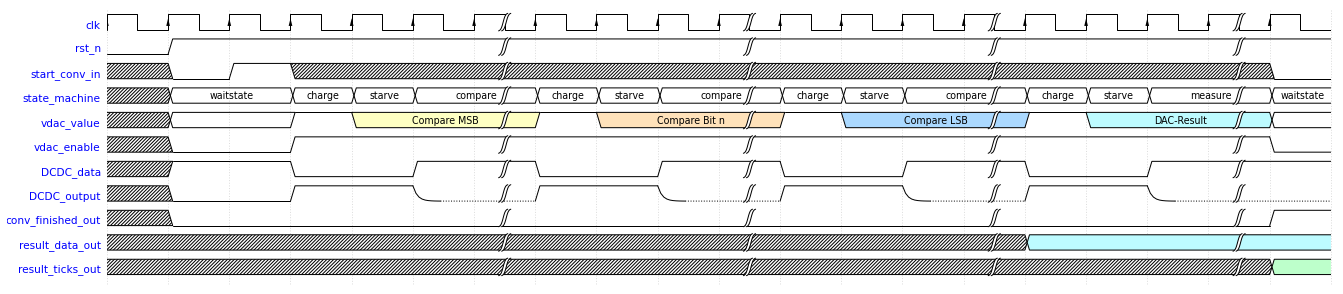

In [7]:
import schemdraw
import schemdraw.elements as elm
import schemdraw.logic as logic
elm.style(elm.STYLE_IEC)

logic.TimingDiagram(
    {'signal': [
        {'name': 'clk', 'wave':               'P.....|...|...|...|.'},
        {'name': 'rst_n', 'wave':             '01....|...|...|...|.'},
        {'name': 'start_conv_in', 'wave':     'x01x..|...|...|...|0'},
        {'name': 'state_machine', 'wave':     'x=.===|===|===|===|=','data':['waitstate','charge','starve','compare','charge','starve','compare','charge','starve','compare','charge','starve','measure','waitstate']},
        {'name': 'vdac_value', 'wave':        'x=.13.|14.|15.|16.|=','data':['','Compare MSB','Compare Bit n','Compare LSB','DAC-Result']},
        {'name': 'vdac_enable', 'wave':       'x0.1..|...|...|...|0'},
        {'name': 'DCDC_data', 'wave':         'x1.0.1|0.1|0.1|0.1|.'},
        {'name': 'DCDC_output', 'wave':       'x0.1.d|1.d|1.d|1.d|.'},
        {'name': 'conv_finished_out', 'wave': 'x0....|...|...|...|1'},
        {'name': 'result_data_out', 'wave':   'x.....|...|...|6..|.'},
        {'name': 'result_ticks_out', 'wave':  'x.....|...|...|...|7'}],
     'config': {'hscale': 2}})

##Figure 5: DAC transfer function, simulation results of output voltage vs DAC code
Simulation has been done off-notebook in an analog simulation. The tools used were `xschem` as schematic editor and `ngspice` as simulation engine in the [iic-osic-tools environment](https://github.com/iic-jku/iic-osic-tools). Shown is the analog DAC output-voltage in dependence of the input DAC-code for a 6-Bit code.

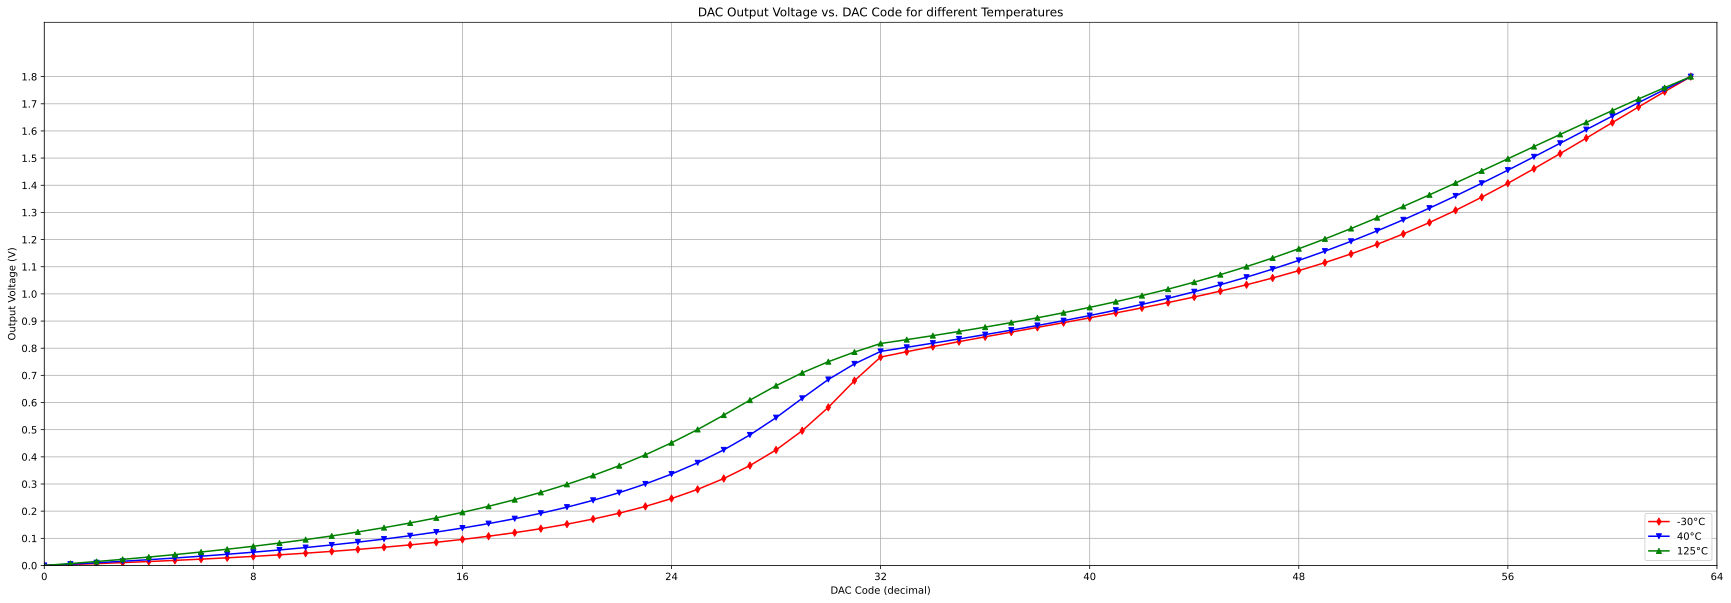

In [8]:
import numpy as np
import matplotlib.pyplot as plt
dac_code = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
data_n30 = [1.11594E-08, 0.00330224, 0.00681034, 0.0105439, 0.0145252, 0.0187792, 0.0233345, 0.0282237, 0.0334843, 0.0391594, 0.0452988, 0.0519605, 0.0592123, 0.067134, 0.0758197, 0.0853814, 0.0959532, 0.107697, 0.120807, 0.135525, 0.152143, 0.171027, 0.192631, 0.217525, 0.246431, 0.280269, 0.320224, 0.367883, 0.425497, 0.496202, 0.582251, 0.680538, 0.767375, 0.787125, 0.806013, 0.824208, 0.841913, 0.859335, 0.876666, 0.894088, 0.91177, 0.929884, 0.948604, 0.968118, 0.988629, 1.01037, 1.03359, 1.05857, 1.08564, 1.11511, 1.14731, 1.18251, 1.22092, 1.26266, 1.30774, 1.35605, 1.4073, 1.46104, 1.51669, 1.57359, 1.63103, 1.68833, 1.74486, 1.8]
data_40 = [1.60761E-08, 0.00485773, 0.0100107, 0.0154861, 0.0213144, 0.0275302, 0.0341722, 0.0412847, 0.0489178, 0.0571289, 0.0659839, 0.0755584, 0.08594, 0.0972301, 0.109547, 0.123029, 0.137838, 0.154166, 0.172238, 0.192324, 0.214743, 0.239876, 0.268178, 0.300193, 0.336572, 0.3781, 0.425742, 0.48071, 0.544312, 0.615481, 0.684919, 0.742436, 0.788233, 0.803322, 0.818598, 0.834157, 0.850104, 0.866551, 0.883627, 0.901467, 0.920225, 0.940065, 0.961161, 0.983696, 1.00784, 1.03375, 1.06156, 1.09138, 1.12328, 1.15734, 1.19362, 1.23215, 1.27291, 1.31583, 1.36075, 1.40744, 1.45559, 1.50482, 1.55472, 1.60486, 1.65483, 1.70423, 1.75273, 1.8]
data_125 = [4.48828E-07, 0.00708991, 0.0145973, 0.0225595, 0.0310175, 0.0400173, 0.0496103, 0.0598545, 0.0708151, 0.0825658, 0.0951902, 0.108783, 0.123452, 0.13932, 0.156528, 0.175236, 0.195628, 0.217914, 0.242337, 0.26917, 0.298728, 0.331365, 0.367477, 0.407488, 0.45181, 0.500685, 0.553715, 0.60887, 0.662025, 0.709447, 0.75038, 0.785905, 0.817298, 0.831556, 0.846316, 0.861656, 0.877658, 0.894417, 0.912036, 0.930631, 0.950331, 0.971278, 0.993628, 1.01755, 1.04321, 1.0708, 1.10045, 1.13227, 1.16631, 1.20248, 1.24064, 1.28057, 1.32202, 1.36472, 1.40841, 1.45279, 1.49757, 1.54247, 1.5872, 1.63149, 1.67511, 1.71785, 1.75952, 1.8]
plt.figure(figsize=(30, 10))
plt.xlabel('DAC Code (decimal)')
plt.ylabel('Output Voltage (V)')
plt.xticks(np.arange(0,65,8))
plt.yticks(np.arange(0,1.9,0.1))
plt.grid()
plt.title('DAC Output Voltage vs. DAC Code for different Temperatures')
plt.plot(dac_code, data_n30, '-rd', label="-30°C", markersize = '5')
plt.plot(dac_code, data_40, '-bv', label="40°C", markersize = '5')
plt.plot(dac_code, data_125, '-g^', label="125°C", markersize = '5')
plt.legend(loc='lower right')
plt.axis([0, 64, 0, 2])
plt.show()

##Figure 6:  Temperature Sensor Output and DCDC Delay CLK Cycles FF/TT/SS
**Simulation environment**: Results have been obtained in a mixed-mode simulation using `xschem` as schematic editor with `ngspice` as simulation engine. The simulation has been done off-notebook in the [iic-osic-tools environment](https://github.com/iic-jku/iic-osic-tools), we present the results due to high demand of computing time (transient, corners `ss` `ff` `tt`, -30°C to +125°C). Synthetisation of the digital core `tempsense_sar_ctrl.v` has been done with OpenLane, afterwards the powered gate-level netlist generated in `*/runs/tempsense_sar_ctrl/results/final/verilog/gl/` has been converted to `xspice` using the scripts `vlog2spice` and `spi2xspice.py` from [qflow](https://github.com/RTimothyEdwards/qflow). The DAC and DCDC have been implemented using true-analog simulation.

```
vlog2Spice foo.vp -l $PDKPATH/libs.ref/sky130_fd_sc_hd/spice/sky130_fd_sc_hd.spice -o foo.spice
python3 spi2xspice.py $PDKPATH/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib -io_time=500p -time=50p -idelay=5p -odelay=50p -cload=250f foo.spice foo.xspice
```

**Subfigure top**: Simulation results of the 6-Bit DAC-Code in the temperature sensor where the DCDC-cell delay-target is set to 256 clock-cycles. The relation between resulting DAC-code and temperature is visible, but also that a post-production-calibration of the sensor curve is mandatory. 

**Subfigure bottom**: The simulation of the actual DCDC delay after the optimum DAC-code has been determined. The difference to the target of 256 clock cycles contains additional information about the current temperature and is (due to strong non-linearity) intended to be used with the DAC-code in a post-calibration look up table (LUT).



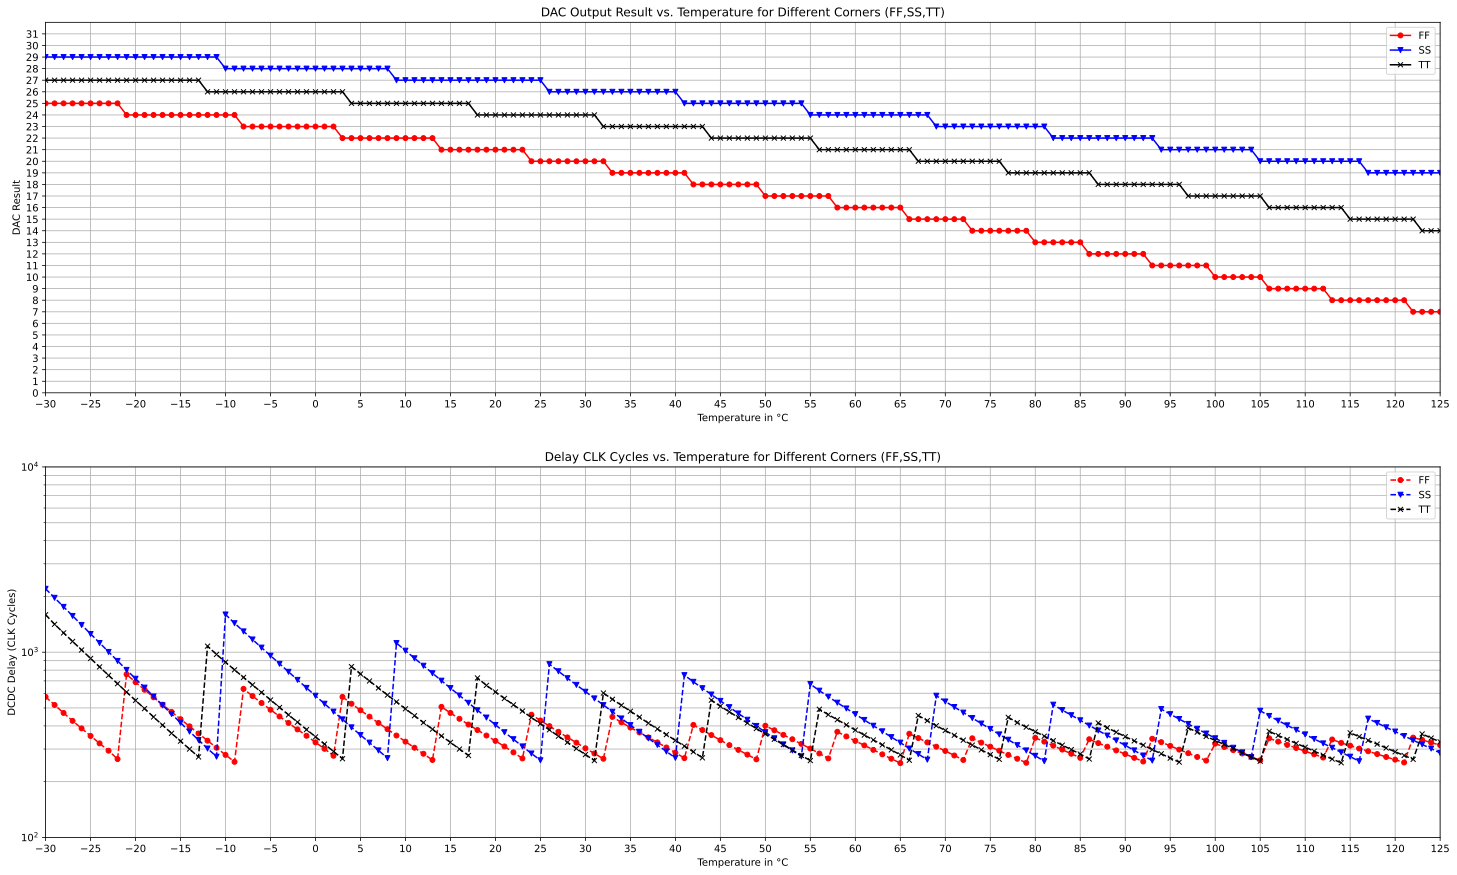

In [9]:
import numpy as np
import matplotlib.pyplot as plt
result_dac_FF = [25,25,25,25,25,25,25,25,25,24,24,24,24,24,24,24,24,24,24,24,24,24,23,23,23,23,23,23,23,23,23,23,23,22,22,22,22,22,22,22,22,22,22,22,21,21,21,21,21,21,21,21,21,21,20,20,20,20,20,20,20,20,20,19,19,19,19,19,19,19,19,19,18,18,18,18,18,18,18,18,17,17,17,17,17,17,17,17,16,16,16,16,16,16,16,16,15,15,15,15,15,15,15,14,14,14,14,14,14,14,13,13,13,13,13,13,12,12,12,12,12,12,12,11,11,11,11,11,11,11,10,10,10,10,10,10,9,9,9,9,9,9,9,8,8,8,8,8,8,8,8,8,7,7,7,7]
result_dac_SS = [29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,25,25,25,25,25,25,25,25,25,25,25,25,25,25,24,24,24,24,24,24,24,24,24,24,24,24,24,24,23,23,23,23,23,23,23,23,23,23,23,23,23,22,22,22,22,22,22,22,22,22,22,22,22,21,21,21,21,21,21,21,21,21,21,21,20,20,20,20,20,20,20,20,20,20,20,20,19,19,19,19,19,19,19,19,19]
result_dac_TT = [27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,25,25,25,25,25,25,25,25,25,25,25,25,25,25,24,24,24,24,24,24,24,24,24,24,24,24,24,24,23,23,23,23,23,23,23,23,23,23,23,23,22,22,22,22,22,22,22,22,22,22,22,22,21,21,21,21,21,21,21,21,21,21,21,20,20,20,20,20,20,20,20,20,20,19,19,19,19,19,19,19,19,19,19,18,18,18,18,18,18,18,18,18,18,17,17,17,17,17,17,17,17,17,16,16,16,16,16,16,16,16,16,15,15,15,15,15,15,15,15,14,14,14]
result_ticks_FF = [574,519,470,426,388,353,322,294,265,759,689,627,571,521,476,435,398,364,333,305,279,256,634,580,532,489,450,415,383,354,326,301,276,574,527,486,449,415,384,355,329,305,283,262,507,470,437,407,380,355,332,310,288,267,460,428,399,372,347,325,303,284,266,448,418,392,369,347,326,306,287,268,405,380,357,335,315,297,280,264,401,379,358,339,320,302,284,267,372,351,332,314,297,281,266,252,363,344,326,309,293,277,262,343,325,309,294,279,266,253,345,329,313,298,283,269,339,323,309,295,282,269,257,341,327,312,298,285,272,260,321,308,296,284,272,261,343,329,316,304,292,281,270,338,324,313,302,292,282,272,263,254,346,336,325,315]
result_ticks_SS = [2199,1966,1757,1570,1403,1254,1121,1003,897,803,719,644,577,517,464,416,373,336,302,273,1598,1434,1295,1171,1059,958,866,784,709,642,582,527,478,434,393,357,325,295,268,1120,1019,927,845,770,702,640,584,533,486,444,405,370,339,310,284,261,862,789,724,666,612,563,518,477,439,404,372,343,316,291,269,752,692,639,591,546,505,467,432,400,370,343,318,295,274,673,620,575,534,497,463,431,401,374,348,325,302,282,263,582,542,506,472,441,412,385,360,337,315,295,276,258,521,487,457,429,402,378,355,334,314,295,277,260,493,463,436,410,386,364,343,324,305,288,271,483,453,427,403,381,360,340,322,305,288,273,258,438,415,393,373,353,335,318,302,286]
result_ticks_TT =  [1593,1415,1271,1143,1028,925,833,750,676,609,549,496,447,404,365,331,300,272,1078,973,883,803,731,666,606,552,503,459,419,382,349,319,291,266,836,763,699,641,587,539,495,454,417,384,353,326,300,277,726,662,610,563,520,481,444,411,381,352,326,302,280,260,602,557,517,480,446,414,385,359,334,311,290,269,551,511,476,444,415,387,362,339,317,296,277,260,492,460,432,405,380,357,336,316,297,279,261,455,427,401,378,356,335,315,297,280,264,445,417,394,372,352,333,315,298,282,265,415,391,370,350,332,315,298,283,268,255,390,370,351,334,318,302,287,272,258,374,355,338,322,307,292,278,265,253,367,350,334,319,304,290,277,264,362,344,328]
temp_vec = np.linspace(-30, 125, len(result_ticks_FF))


# DAC y axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 15))

ax1.set_xlabel('Temperature in °C')
ax1.set_ylabel('DAC Result')
ax1.set_ylim(0,32)
ax1.set_yticks(np.arange(0,32,1))
ax2.set_xlabel('Temperature in °C')
ax2.set_ylabel('DCDC Delay (CLK Cycles)')
ax1.set_xticks(np.arange(-30,130,5))
ax1.set_xlim(-30,125)

# DCDC delay y axis
ax2.set_yscale('log')
ax2.set_ylim(100,10000)

ax2.grid(True, which="both", ls="-")
ax1.grid(True, which="both", ls="-")

ax2.set_xticks(np.arange(-30,130,5))
ax2.set_xlim(-30,125)

ax1.plot(temp_vec, result_dac_FF, '-ro', label="FF", markersize = '5')
ax1.plot(temp_vec, result_dac_SS, '-bv', label="SS", markersize = '5')
ax1.plot(temp_vec, result_dac_TT, '-kx', label="TT", markersize = '5')

ax2.plot(temp_vec, result_ticks_FF, '--ro', label="FF", markersize = '5')
ax2.plot(temp_vec, result_ticks_SS, '--bv', label="SS", markersize = '5')
ax2.plot(temp_vec, result_ticks_TT, '--kx', label="TT", markersize = '5')

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax1.set_title('DAC Output Result vs. Temperature for Different Corners (FF,SS,TT)')
ax2.set_title('Delay CLK Cycles vs. Temperature for Different Corners (FF,SS,TT)')

plt.show()


# Implementation

First create the Verilog-HDL files and configuration. Then harden the macrocell with [OpenLane](https://github.com/The-OpenROAD-Project/OpenLane/), an automated Open-Source RTL2GDS flow. The Verilog sources and configurations are set up for a result based on the [SKY130A PDK](https://github.com/google/skywater-pdk/).

### Write Verilog `tempsense.v`, `tempsense_sar_ctrl.v`, `vdac.v` and `vdac_cell.v`

* `tempsense` is the top-level module of the temperature sensor.
  *  `parameter DAC_RESOLUTION`: Set the number of bits used for the DAC input code. With higher resolution the DAC voltage step-size at the output becomes smaller. 
  *  `parameter COUNTER_BITWIDTH`: Number of max. clock cycles that can be measured after the DAC code has been obtained. If there is no clipping in a Fig.6 like simulation then the number of bits is sufficiently high. `(COUNTER_BITWIDTH-4)^2` is the SAR-target of the DCDC delay.
* `tempsense_sar_ctrl` is the digital core which handles the SAR algorithm.
* `vdac` is the top-level of the voltage DAC.
* `vdac_cell` is the central component of the DAC. 2 instances of the tristate-inverter `sky130_fd_sc_hd__einvp` allow the cell to switch between 4 modes: `Pullup`, `Pulldown`, `Vref`, and `High-Z`. Parameter `PARALLEL_CELLS` sets the amount of parallel tristate-inverters.


In [10]:
%%writefile tempsense.v
module tempsense #(parameter DAC_RESOLUTION = 6,
                   parameter COUNTER_BITWIDTH = 12) (
  input wire clk,
  input wire rst_n,
  input wire start_conv_in,
  output wire [DAC_RESOLUTION-1:0] vdac_result_out,
  output wire [COUNTER_BITWIDTH-1:0] tick_result_out,
  output wire conversion_finished_out
  );

  // Digital core with SAR-algoritm
  tempsense_sar_ctrl #(.DAC_RESOLUTION(DAC_RESOLUTION),
                       .COUNTER_BITWIDTH(COUNTER_BITWIDTH)) sar 
                       (
                        .clk(clk),
                        .rst_n(rst_n),
                        .start_conv_in(start_conv_in),
                        .dac_result_out(vdac_result_out),
                        .ticks_out(tick_result_out),
                        .conv_finished_out(conversion_finished_out),
                        .vdac_data_out(dac_data_w),
                        .vdac_enable_out(dac_enable_w),
                        .dcdc_dat_out(dcdc_data_w),
                        .time_trigd_n_in(dcdc_trigd_n_w)
   );
  
  // Voltage-mode Digital to Analog Converter (VDAC)
  wire [DAC_RESOLUTION-1:0] dac_data_w;
  wire dac_enable_w;
  wire dcdc_data_w;
  wire dcdc_enable_ana_w;
  vdac #(.RESOLUTION(DAC_RESOLUTION)) dac
        (
         .data(dac_data_w),
         .enable(dac_enable_w),
         .vout_ana_(dcdc_enable_ana_w)
        );

  // Digitally-Controled Delay Cell
  wire dcdc_trig_n_ana_w;
  wire dcdc_trigd_w;
  wire dcdc_trigd_n_w;
  sky130_fd_sc_hd__einvp_1 dcdc (.A(dcdc_data_w), .TE(dcdc_enable_ana_w), .Z(dcdc_trig_n_ana_w));
  sky130_fd_sc_hd__inv_4   inv1 (.A(dcdc_trig_n_ana_w),.Y(dcdc_trigd_w));
  sky130_fd_sc_hd__inv_12  inv2 (.A(dcdc_trigd_w),.Y(dcdc_trigd_n_w));
  
endmodule


Writing tempsense.v


In [11]:
%%writefile tempsense_sar_ctrl.v
/*
  clk=10MHz SAR-Algorithm for Digitally Controlled Delay Cell (DCDC) temperature sensor.
  Computes the Digital-Analog-Converter (DAC) code where the Delay-cell creates a preset delay of 
  2^(COUNTER_BITWIDTH-4) clk-cycles, which is a vague information about the current temperature.
  The detailing temperature-information is confined in the residual delay-time of
  the delaycell trigger-signal to 2^COUNTER_BITWIDTH-1 clk-cycles.
  
  With the preset parameters the comparison for DAC-code approximation happens
  at 2^(COUNTER_BITWIDTH-4)=256 clock cycles, while the max. measured delay
  is 2^COUNTER_BITWIDTH-1 = 4095 cycles.

  State machine:
    State 1: Wait for start-trigger
    State 2: Charge DCDC cell to maximize output voltage
    State 3: Starve DCDC cell (preset the lower DAC voltage).
             Goto state 3 if the approximation of the DAC code is not finished yet, 
             otherwise goto state 5.
    State 4: Check if the current delay is less or greater 2^(COUNTER_BITWIDTH-4) cycles, 
             update DAC code depending on the result.
             Return to state 2.
    State 5: Measure the residual delay-time of the DCDC cell for additional temperature information. 
*/
`default_nettype none
module tempsense_sar_ctrl #(parameter DAC_RESOLUTION = 6,
                            parameter COUNTER_BITWIDTH = 12) (
   // control
   input wire clk, 
   input wire rst_n,
   input wire start_conv_in,
   // results
   output reg [DAC_RESOLUTION-1:0]  dac_result_out,
   output reg [COUNTER_BITWIDTH-1:0] ticks_out,
   output reg conv_finished_out,
   //vdac interface
   output wire [DAC_RESOLUTION-1:0] vdac_data_out,
   output wire vdac_enable_out,
   // dcdc interface
   output wire dcdc_dat_out,
   input wire time_trigd_n_in
   );

   // to output
   wire [5:0] next_dac_result_w;
   wire       next_conv_finished_w;
   
   // DAC code handling
   reg  [DAC_RESOLUTION-1:0] dac_value_r;
   wire [DAC_RESOLUTION-1:0] next_dac_value_w;
   reg  [COUNTER_BITWIDTH-1:0] counter_r;
   wire [COUNTER_BITWIDTH-1:0] next_counter_w;
   reg  [COUNTER_BITWIDTH-1:0] ticks_r;
   wire [COUNTER_BITWIDTH-1:0] next_ticks_w;
   wire [COUNTER_BITWIDTH-1:0] next_ticks_out_w;
   reg  [DAC_RESOLUTION-1:0] current_dac_bit_r;
   wire [DAC_RESOLUTION-1:0] next_dac_bit_w;

   wire time_trigd_w = ~time_trigd_n_in;

   // State machine
   reg  [2:0] state_r;
   wire [2:0] next_state_w;
   localparam [2:0] 
    waitstate    = 3'b000,  // everything disabled
    charge_dcdc  = 3'b001,  // DCDC gets precharged (VDAC set to VDD, tri-inverter input set to 0, output thus to VDD)
    starve_dcdc  = 3'b010,  // transition into starved discharge mode (VDAC set to lower voltage, tri-inverter input unchanged)
    compare  = 3'b011,      // current-starved discharge, find SAR code (VDAC kept at lower voltage, tri-inverter input set to 1, thus output pulling to VSS)
    count_delay  = 3'b100;  // current-starved discharge, measure residual delay (VDAC kept at lower voltage, tri-inverter input set to 1, thus output pulling to VSS)

   //******************************************
   //   Synchronous process and Reset Handling
   //******************************************
   always @(posedge clk, negedge rst_n) begin
      if (rst_n == 1'b0) begin  
         dac_result_out        <= {DAC_RESOLUTION{1'b0}};
         dac_value_r           <= {DAC_RESOLUTION{1'b0}};
         conv_finished_out     <= 1'b0;
         counter_r             <= {{(COUNTER_BITWIDTH-1){1'b0}},1'b1};
         state_r               <= waitstate;
         current_dac_bit_r     <= {1'b1,{(DAC_RESOLUTION-1){1'b0}}};
         ticks_r               <= {COUNTER_BITWIDTH{1'b0}};
         ticks_out             <= {COUNTER_BITWIDTH{1'b0}};
      end 
      else begin	
         dac_result_out        <= next_dac_result_w;
         dac_value_r           <= next_dac_value_w;
         conv_finished_out     <= next_conv_finished_w;
         counter_r             <= next_counter_w;
         state_r               <= next_state_w;
         current_dac_bit_r     <= next_dac_bit_w;
         ticks_r               <= next_ticks_w;
         ticks_out             <= next_ticks_out_w;
      end
   end 

   //******************************************
   //   Combinatoric process handling
   //******************************************
   wire is_conversion_starting_w = (state_r == waitstate) & start_conv_in;
   wire compare_end_w = counter_r[COUNTER_BITWIDTH-4] == 1; // count-goal is 256
   wire count_ticks_end_w = (~counter_r) == {COUNTER_BITWIDTH{1'b0}};  // count residual until 4095
   wire is_last_bit_w    = current_dac_bit_r == {{(DAC_RESOLUTION-1){1'b0}},1'b1};
   wire is_returning_to_waitstate_w = count_ticks_end_w;
   wire comparison_done = current_dac_bit_r == {(DAC_RESOLUTION){1'b0}};

   /***************************
    State machine combinatorics
    **************************/
   // Count up when in count-state, otherwise reset counter
   wire [COUNTER_BITWIDTH-1:0] counter_reset = {{(COUNTER_BITWIDTH-1){1'b0}},1'b1};
   wire [COUNTER_BITWIDTH-1:0] one_vector = {{(COUNTER_BITWIDTH-1){1'b0}},1'b1};
   assign next_counter_w = (state_r == compare) & compare_end_w  ? counter_reset : 
                           (state_r == count_delay) & count_ticks_end_w ? counter_reset : 
                           state_r == compare     ? counter_r + one_vector : 
                           state_r == count_delay ? counter_r + one_vector :
                           counter_reset;

   // DAC-Value handling with binary SAR algorithm
   assign next_dac_bit_w = is_returning_to_waitstate_w ? {1'b1,{(DAC_RESOLUTION-1){1'b0}}} :
                           compare_end_w ? current_dac_bit_r >> 1 : 
                           current_dac_bit_r ;

   assign next_dac_value_w = state_r == waitstate    ? {DAC_RESOLUTION{1'b0}} :
                             state_r == compare & compare_end_w & ~time_trigd_w ? (dac_value_r | current_dac_bit_r) : 
                                                                                  dac_value_r;  

   assign next_dac_result_w = (is_last_bit_w  & compare_end_w ) ?  dac_value_r | {{(DAC_RESOLUTION-1){1'b0}},(~time_trigd_w)} : 
                                                                   dac_result_out ;
   
   // handle conv_finished output
   assign next_conv_finished_w = is_conversion_starting_w ? 1'b0 :
                                 is_returning_to_waitstate_w ? 1'b1 : 
                                 conv_finished_out; 
   
   // Counting clock-cylces of the last state 
   // until the delay cell triggers for additional temperature reading
   assign next_ticks_w = (state_r == count_delay) & (time_trigd_w == 0) ? counter_r : ticks_r;
   assign next_ticks_out_w = is_returning_to_waitstate_w ? next_ticks_w : ticks_out;
   
   /***************************
    VDAC output control signals
    **************************/
   assign vdac_data_out   = state_r == charge_dcdc ? {DAC_RESOLUTION{1'b1}} : (dac_value_r | current_dac_bit_r);
   assign vdac_enable_out = state_r == waitstate   ? 1'b0 : 1'b1; 

   /***************************
    DCDC output control signals
    **************************/
   assign dcdc_dat_out = state_r == charge_dcdc ? 1'b0 : 
                         state_r == starve_dcdc ? 1'b0 : 
                         1'b1;
                         
   /***************************
    State machine control
    **************************/
   assign next_state_w = state_r==waitstate   ? (start_conv_in ? charge_dcdc : state_r) : 
                         state_r==charge_dcdc ? starve_dcdc :
                         state_r==starve_dcdc ? (comparison_done ? count_delay : compare) :
                         state_r==compare     ? (compare_end_w ? charge_dcdc : state_r) :
                         state_r==count_delay ? (is_returning_to_waitstate_w ? waitstate : count_delay) :
                         waitstate;
endmodule





Writing tempsense_sar_ctrl.v


In [12]:
%%writefile vdac.v
module vdac #(parameter RESOLUTION = 6)(
  input wire [RESOLUTION-1:0] data,
  input wire enable,
  output wire vout_ana_
  );
  genvar i;
  generate 
    for (i = 0; i<RESOLUTION-1; i=i+1) begin : parallel_cells
      vdac_cell #(.PARALLEL_CELLS(2**i)) vdac_batch (
        .sign(data[RESOLUTION-1]),
        .data(data[i]),
        .enable(enable),
        .vout_ana_(vout_ana_)
      );
    end
  endgenerate

  // vdac-unitcell for transition from Din=011..11 to Din=100..00
  vdac_cell #(.PARALLEL_CELLS(1)) vdac_single (
    .sign(1'b0),
    .data(1'b0),
    .enable(enable & (~data[RESOLUTION-1])),
    .vout_ana_(vout_ana_)
  );
endmodule


Writing vdac.v


In [13]:
%%writefile vdac_cell.v
module vdac_cell #(parameter PARALLEL_CELLS = 4)(
  input wire sign,
  input wire data,
  input wire enable,
  output wire vout_ana_
  );
  wire en_vref, en_pupd, npu_pd;

  // control logic
  assign npu_pd  = ~data;
  assign en_pupd = enable & (~(sign^data));
  assign en_vref = enable & (sign^data);

  // Batch of parallel vdac-unitcells
  genvar i;
  generate
    for (i=0; i < PARALLEL_CELLS; i=i+1) begin : einvp_batch
      sky130_fd_sc_hd__einvp_1 pupd (.A(npu_pd), .TE(en_pupd), .Z(vout_ana_));
      sky130_fd_sc_hd__einvp_1 vref (.A(vout_ana_), .TE(en_vref), .Z(vout_ana_));
    end
  endgenerate
endmodule


Writing vdac_cell.v


## Write configuration `config.tcl` for OpenLane

In [14]:
%%writefile config.tcl
set ::env(DESIGN_NAME) tempsense

set ::env(CLOCK_PORT) "clk"
set ::env(CLOCK_NET) "clk"
set ::env(CLOCK_TREE_SYNTH) 1
set ::env(CLOCK_PERIOD) 100

# Input files
set ::env(VERILOG_FILES) "vdac.v vdac_cell.v tempsense_sar_ctrl.v tempsense.v"

# Interpret instantiated SKY130-Standardcells as blackbox
set ::env(SYNTH_READ_BLACKBOX_LIB) 1

# Rexeg to flag nets where buffers are not allowed (analog signals)
set ::env(RSZ_DONT_TOUCH_RX) "_ana_" 

# Floorplanning
set ::env(FP_SIZING) "relative"
set ::env(FP_CORE_UTIL) 60

# Power distribution network settings
set ::env(FP_PDN_HOFFSET) 12
set ::env(FP_PDN_VOFFSET) 12
set ::env(FP_PDN_HPITCH) 12
set ::env(FP_PDN_VPITCH) 24
        
# PDN on Macro Level
set ::env(DESIGN_IS_CORE) 0
set ::env(FP_PDN_CORE_RING) 0
set ::env(RT_MAX_LAYER) {met4}
set ::env(VDD_NETS) [list {VPWR}]
set ::env(GND_NETS) [list {VGND}]

# Placement
set ::env(PL_TARGET_DENSITY) {0.80}
set ::env(PL_BASIC_PLACEMENT) 0
set ::env(DPL_CELL_PADDING) 2
set ::env(PL_RESIZER_TIMING_OPTIMIZATIONS) {0}
set ::env(PL_RESIZER_DESIGN_OPTIMIZATIONS) {1}
set ::env(DIODE_INSERTION_STRATEGY) 4

# Router
set ::env(GLB_RESIZER_TIMING_OPTIMIZATIONS) {0}

# LVS - workaround because LVS will fail with GDS at OpenLane commit a0b19fa
 set ::env(MAGIC_EXT_USE_GDS) 0

# disable CVC because of https://github.com/hdl/conda-eda/issues/174
set ::env(RUN_CVC) 0

Writing config.tcl


## Run `OpenLane` RTL2GDS Flow

In [15]:
OPENLANE_ROOT=str(pathlib.Path('OpenLane').resolve())
PATH=os.environ['PATH']
%env PDK_ROOT={CONDA_PREFIX}/share/pdk
%env PDK=sky130A
%env STD_CELL_LIBRARY=sky130_fd_sc_hd
%env STD_CELL_LIBRARY_OPT=sky130_fd_sc_hd
%env TCLLIBPATH={CONDA_PREFIX}/lib/tcllib1.20
%env OPENLANE_ROOT={OPENLANE_ROOT}
%env PATH={PATH}:{OPENLANE_ROOT}:{OPENLANE_ROOT}/scripts
%env OPENLANE_LOCAL_INSTALL=1
!flow.tcl -design . -tag tempsense -overwrite -ignore_mismatches

env: PDK_ROOT=/content/conda-env/share/pdk
env: PDK=sky130A
env: STD_CELL_LIBRARY=sky130_fd_sc_hd
env: STD_CELL_LIBRARY_OPT=sky130_fd_sc_hd
env: TCLLIBPATH=/content/conda-env/lib/tcllib1.20
env: OPENLANE_ROOT=/content/OpenLane
env: PATH=/content/conda-env/bin:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/content/OpenLane:/content/OpenLane/scripts
env: OPENLANE_LOCAL_INSTALL=1
OpenLane ff85171cfb10dc44911db7a62cc2d86f03807756
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[WARNING]: OpenLane may not function properly: 'OL_INSTALL_DIR'
The version of open_pdks used in building the PDK does not match the version OpenLane was tested on (installed: a519523b0d9bc913a6f87a5eed083597ed9e2e93, tested: 3af133706e554a740cfe60f21e773d9eaa41838c)
This may introduce some issue

### Note about fanout-violations
There is a high number of connected `einvp` Output-Pins `Z` which is the analog net in this design, and each of those is counted as fanout. These can be seen as false-positive fanout- and capacitance-violations. See entries of `einvp`-output `Z` in the following logfile. 

If there are other nets listed in the logfile: Check if it is due to Antenna-Diodes, because those violations can be ignored too. E.g. 10 fanouts + 10 antenna-diodes = 20 fanouts is not an error. 

In [16]:
with open('runs/tempsense/reports/signoff/24-rcx_sta.slew.rpt') as f:
    lines = f.readlines()
lines

['\n',
 '===========================================================================\n',
 ' report_check_types -max_slew -max_cap -max_fanout -violators\n',
 '============================================================================\n',
 'max fanout\n',
 '\n',
 'Pin                                   Limit Fanout  Slack\n',
 '---------------------------------------------------------\n',
 'dac.parallel_cells[0].vdac_batch.einvp_batch[0].pupd/Z     10     33    -23 (VIOLATED)\n',
 'dac.parallel_cells[0].vdac_batch.einvp_batch[0].vref/Z     10     33    -23 (VIOLATED)\n',
 'dac.parallel_cells[1].vdac_batch.einvp_batch[0].pupd/Z     10     33    -23 (VIOLATED)\n',
 'dac.parallel_cells[1].vdac_batch.einvp_batch[0].vref/Z     10     33    -23 (VIOLATED)\n',
 'dac.parallel_cells[1].vdac_batch.einvp_batch[1].pupd/Z     10     33    -23 (VIOLATED)\n',
 'dac.parallel_cells[1].vdac_batch.einvp_batch[1].vref/Z     10     33    -23 (VIOLATED)\n',
 'dac.parallel_cells[2].vdac_batch.einvp_batch[0].

## Graphical representation of the hierarchy generated by `OpenLane`/`yosys`

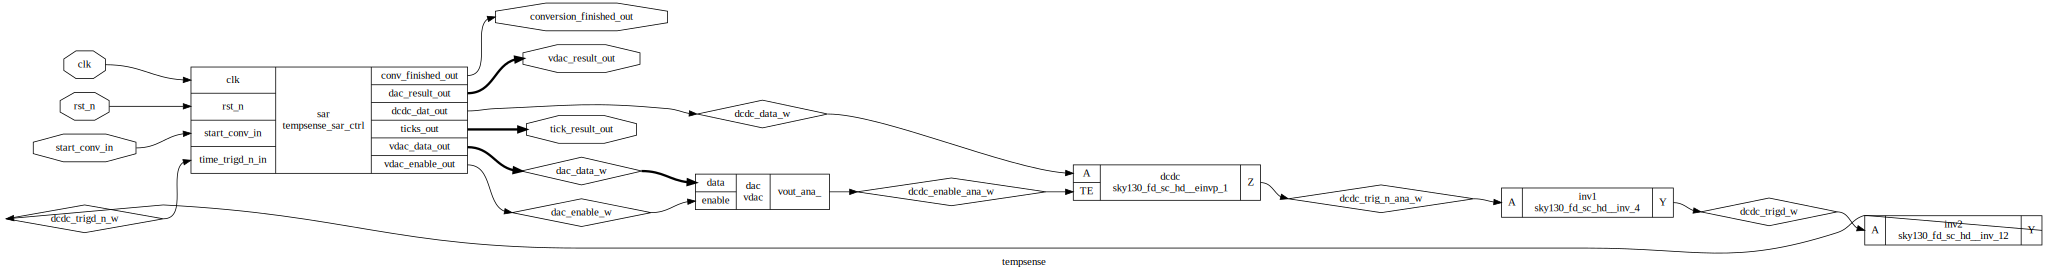

In [17]:
from graphviz import Source
path = 'runs/tempsense/tmp/synthesis/hierarchy.dot'
s = Source.from_file(path)
s.render('hierarchy', format='svg',view=True)
IPython.display.SVG('hierarchy.svg')

## Plot of the GDS data of the hardened macrocell generated by OpenLane-flow
The current [chip-integration methodology](https://github.com/The-OpenROAD-Project/OpenLane/blob/master/docs/source/usage/chip_integration.md) of `OpenLane` is 
* harden the hard macros 
* harden the chip-core containing all the hard macros and everything else 
* harden the padframe
* harden the full chip  

Followed by this, the temperature sensor could be handled as a hard-macro and be placed on chip-core level wherever temperature-readings are needed. 

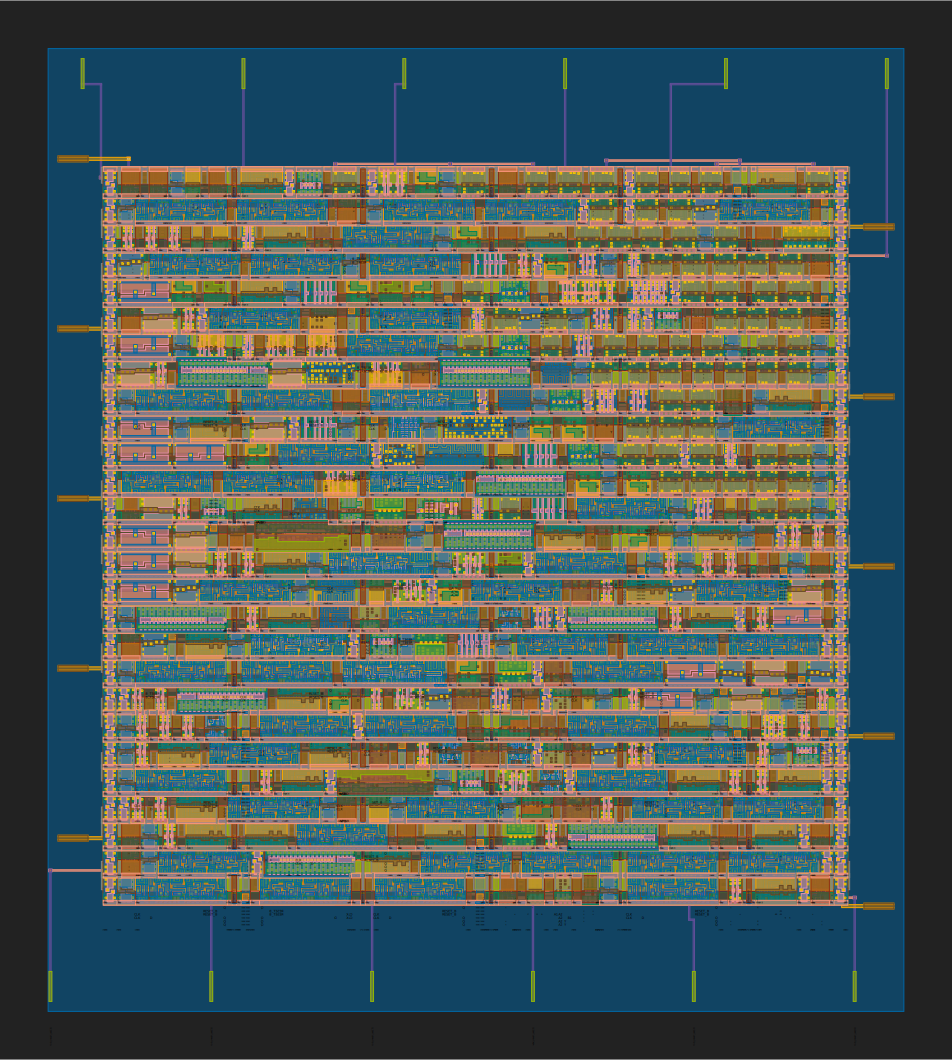

In [18]:
# Python imports
from graphviz import Source
import gdstk
gdss = sorted(pathlib.Path('runs').glob('*/results/final/gds/*.gds'))
library = gdstk.read_gds(gdss[-1])
top_cells = library.top_level()
top_cells[0].write_svg('vdac.svg')
IPython.display.SVG('vdac.svg')


## Appendix 1: Gate-level implementation of a DAC slice

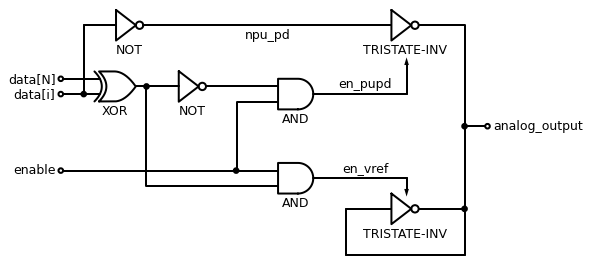

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import schemdraw
import schemdraw.elements as elm
import schemdraw.logic as logic
elm.style(elm.STYLE_IEC)
with schemdraw.Drawing() as d:
  # elements
  xor_sign = d.add(logic.Xor().label('XOR',loc='bottom').at((1,0)))
  inverter1 = d.add(logic.Not().label('NOT',loc='bottom'))
  and2_en_pupd = d.add(logic.And().label('AND',loc='bottom').at((7,-0.25)))
  and1_en_vref = d.add(logic.And().label('AND',loc='bottom').at((7,-3)))
  inverter2 = d.add(logic.Not().label('NOT',loc='bottom').at((1,2)))

  einvp1 = d.add(logic.Not().label('TRISTATE-INV',loc='bottom').at((10,2)))
  einvp2 = d.add(logic.Not().label('TRISTATE-INV',loc='bottom').at((10,-4)))

  # sign input
  in_sign = d.add(elm.Line().left().length(0.25*d.unit).at(xor_sign.in1))
  d += elm.Dot(open=True).label('data[N]',loc='left')
  # data input
  d += elm.Line().left().length(0.25*d.unit).at(xor_sign.in2)
  d += elm.Dot(open=True).label('data[i]',loc='left')

  # enable input
  d += elm.Line().left().length(0.34*d.unit).at(and1_en_vref.in1)
  d += elm.Dot()
  d += elm.Line().left().length(0.66*d.unit).at(and1_en_vref.in1)
  d += elm.Line().left().length(2.25*d.unit).at(and1_en_vref.in1)
  d += elm.Dot(open=True).label('enable',loc='left')
    
  # inverter data
  d += elm.Wire('-|').at(inverter1.out).to(and2_en_pupd.in1)  
  d += elm.Wire('c', k=-1).at(and1_en_vref.in1).to(and2_en_pupd.in2)  
    
  # xor out
  d += elm.Wire('|-',arrow='o-').at(xor_sign.in2).to(inverter2.in1)
  d += elm.Wire('|-',arrow='o-').at(xor_sign.out).to(and1_en_vref.in2) 

  # top hi-z-buffer
  d += elm.Wire('|-').at(inverter2.out).to(einvp1.in1).label('npu_pd')
  d += elm.Line().at(and1_en_vref.out).right().label('en_vref').length(d.unit*0.9)
  d += elm.Line(arrow='->').down().length(d.unit*0.2)
  
  d += elm.Line().at(and2_en_pupd.out).right().label('en_pupd').length(d.unit*0.9)
  d += elm.Line(arrow='->').up().length(d.unit*0.4)

  # inv loop
  d += elm.Line().at(einvp2.in1).left().length(d.unit/2)
  d += elm.Line().down().length(d.unit/2)
  d += elm.Line().right().length(1.3*d.unit)
  d += elm.Line().up().length(d.unit/2)
  d += elm.Line().left().length(d.unit/4)

  # output
  d += elm.Line().at(einvp2.out).right().length(0.5*d.unit)
  d += elm.Dot()
  d += elm.Line().up().length(0.9*d.unit)
  d += elm.Dot()
  d += elm.Line().right().length(0.25*d.unit)
  d += elm.Dot(open=True).label('analog_output',loc='right')
  d += elm.Wire('c',k=1.5).at(einvp1.out).to(einvp2.out)  


## Appendix 2: Synthesis result of a DAC slice using `einvp`-cells

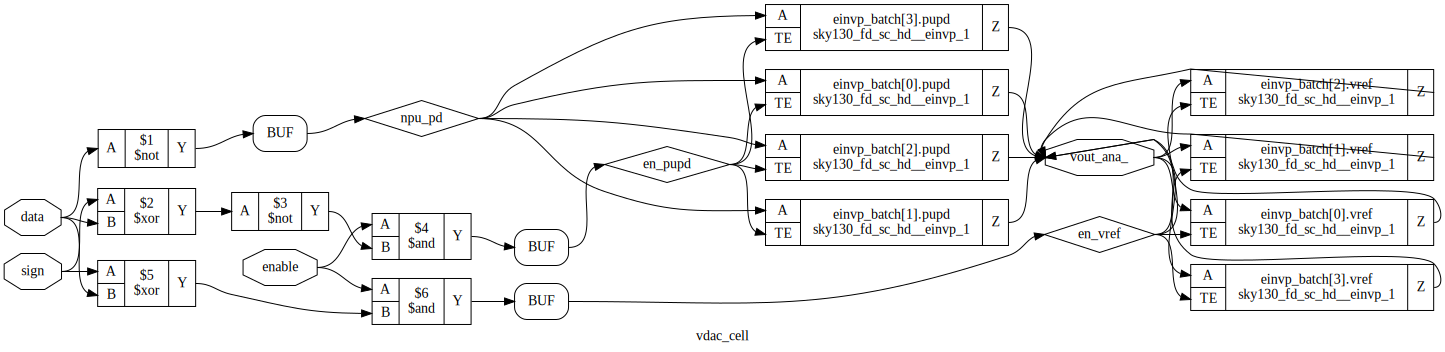

In [20]:
from graphviz import Source
!yosys -q -p "read_verilog vdac_cell.v" -p "read_verilog conda-env/share/pdk/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd.v" -p "hierarchy -top vdac_cell" -p "select -module vdac_cell" -p "show -format dot -prefix vdac_cell" -p "select -clear"
s = Source.from_file('vdac_cell.dot')
s.render('vdac_cell', format='svg',view=True)
IPython.display.SVG('vdac_cell.svg')